## Set `UR5` Robot

In [25]:
import sys 
sys.path.append("..")
import cv2 
import numpy as np 
import time
import rospy
from sensor_msgs.msg import JointState
import matplotlib.pyplot as plt 
print("Done.")


Done.


### Define `UR` Class

In [27]:
class UR_Test():
    def __init__(self):
        self.tick = 0
        self.joint_list = None 
        self.joint_sub = rospy.Subscriber('/joint_states', JointState, self.joint_callback)

        tic_temp=0 

        while self.tick<2: 
            time.sleep(1e-3)
            tic_temp=tic_temp+1

            if tic_temp>5000: 
                print ("[ERROR] GET JOINTS")
                break 
            
    def joint_callback(self, joint_msg):
        """
            Get joint values about each joint.
        """
        self.tick+=1 
        self.joint_list = joint_msg 

#### Before run below code, you should run this line
`roslaunch ur_modern_driver ur5_bringup.launch robot_ip:=192.168.0.100`  in terminal.

In [7]:
!roslaunch ur_modern_driver ur5_bringup.launch robot_ip:=192.168.0.100

... logging to /home/rilab/.ros/log/729ee8d4-a85d-11ed-b717-c7cd5ec2be1a/roslaunch-rilab-XPS-15-9500-55372.log
Checking log directory for disk usage. This may take a while.
Press Ctrl-C to interrupt
Done checking log file disk usage. Usage is <1GB.
]2;/home/rilab/catkin_qd/src/ur_modern_driver/launch/ur5_bringup.launch
xacro: in-order processing became default in ROS Melodic. You can drop the option.
started roslaunch server http://rilab-XPS-15-9500:40129/

SUMMARY

PARAMETERS
 * /robot_description: <?xml version="1....
 * /rosdistro: noetic
 * /rosversion: 1.15.15
 * /ur_driver/base_frame: base
 * /ur_driver/max_payload: 5.0
 * /ur_driver/max_velocity: 10.0
 * /ur_driver/min_payload: 0.0
 * /ur_driver/prefix: 
 * /ur_driver/robot_ip_address: 192.168.0.100
 * /ur_driver/servoj_time: 0.008
 * /ur_driver/tool_frame: tool0_controller

NODES
  /
    robot_state_publisher (robot_state_publisher/robot_state_publisher)
    ur_driver (ur_modern_driver/ur_driver)

auto-starting new master
pro

In [5]:
rospy.init_node('test')
ur_test = UR_Test()

print(ur_test.joint_list.position)
joint_value = ur_test.joint_list.position

(-1.5739653746234339, -2.314601560632223, 2.145999256764547, 1.740140123958252, 0.7839429378509521, -1.5683963934527796)


### Load Mujoco Engine

In [1]:
import mujoco
import numpy as np
import matplotlib.pyplot as plt
from mujoco_parser import MuJoCoParserClass
from util import sample_xyzs,rpy2r,r2quat
np.set_printoptions(precision=2,suppress=True,linewidth=100)
plt.rc('xtick',labelsize=6); plt.rc('ytick',labelsize=6)
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
print ("MuJoCo version:[%s]"%(mujoco.__version__))

MuJoCo version:[2.3.4]


### Parse

In [2]:
xml_path = '../asset/ur5e/scene_ur5e_rg2_obj.xml'
env = MuJoCoParserClass(name='UR5e with RG2 gripper',rel_xml_path=xml_path,VERBOSE=True)
obj_names = [body_name for body_name in env.body_names
             if body_name is not None and (body_name.startswith("obj_"))]
n_obj = len(obj_names)
# Place objects in a row
xyzs = sample_xyzs(n_sample=n_obj,
                   x_range=[0.45,1.65],y_range=[-0.38,0.38],z_range=[0.81,0.81],min_dist=0.2)
colors = np.array([plt.cm.gist_rainbow(x) for x in np.linspace(0,1,n_obj)])
for obj_idx,obj_name in enumerate(obj_names):
    jntadr = env.model.body(obj_name).jntadr[0]
    env.model.joint(jntadr).qpos0[:3] = xyzs[obj_idx,:]
    geomadr = env.model.body(obj_name).geomadr[0]
    env.model.geom(geomadr).rgba = colors[obj_idx] # color

# Move tables and robot base
env.model.body('base_table').pos = np.array([0,0,0])
env.model.body('front_object_table').pos = np.array([1.05,0,0])
env.model.body('side_object_table').pos = np.array([0,-0.85,0])
env.model.body('base').pos = np.array([0,0,0.8])
print ("Ready.")

dt:[0.0020] HZ:[500]
n_body:[52]
geom_names:['floor', None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None]
n_body:[29]
body_names:['world', 'base', 'shoulder_link', 'upper_arm_link', 'forearm_link', 'wrist_1_link', 'wrist_2_link', 'wrist_3_link', 'tcp_link', 'camera_mount', 'rg2_gripper_base_link', 'camera_center', 'rg2_gripper_finger1_finger_link', 'rg2_gripper_finger1_inner_knuckle_link', 'rg2_gripper_finger1_finger_tip_link', 'rg2_gripper_finger2_finger_link', 'rg2_gripper_finger2_inner_knuckle_link', 'rg2_gripper_finger2_finger_tip_link', 'front_object_table', 'side_object_table', 'base_table', 'obj_cylinder_01', 'obj_cylinder_02', 'obj_cylinder_03', 'obj_cylinder_04', 'obj_cylinder_05', 'obj_cylinder_06', 'obj_cylinder_07', 'obj_cyl

In [3]:
joint_names = env.rev_joint_names[:6]
idxs_forward = [env.model.joint(joint_name).qposadr[0] for joint_name in env.joint_names[:6]]
idxs_jacobian = [env.model.joint(joint_name).dofadr[0] for joint_name in env.joint_names[:6]]
list1, list2 = env.ctrl_joint_idxs, idxs_forward
idxs_step = []
for i in range(len(list2)):
    if list2[i] not in list1:
        idxs_step.append(list1.index(list2[i]))
        

In [4]:
joint_value = [-1.5739653746234339, -2.314601560632223, 2.145999256764547, 1.740140123958252, 0.7839429378509521, -1.5683963934527796]

### Solve Inverse Kinematics on `Mujoco Engine`

In [7]:
R_trgt = rpy2r(np.radians([-180,0,90]))

q_ik = env.solve_ik(
    body_name='tcp_link',p_trgt=np.array([0.5, 0.3, 1.20]),R_trgt=R_trgt,
    IK_P=True,IK_R=True, q_init=joint_value,idxs_forward=idxs_forward, idxs_jacobian=idxs_jacobian,
    RESET=False,DO_RENDER=False,render_every=10,th=1*np.pi/180.0,err_th=1e-3)

print(q_ik)

[-1.86 -3.26  1.86  1.4  -0.29 -0.  ]


Pressed ESC
Quitting.


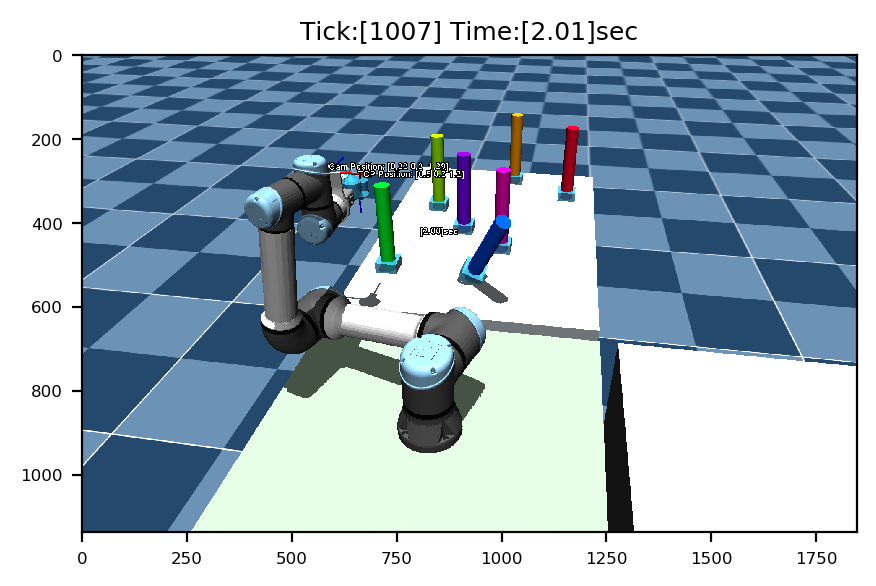

Done.


In [14]:
env.init_viewer(viewer_title='UR5e with RG2 gripper',viewer_width=1200,viewer_height=800,
                viewer_hide_menus=True)
env.update_viewer(azimuth=174.08,distance=2.76,elevation=-33,lookat=[0.1,0.05,0.16],
                  VIS_TRANSPARENT=False,VIS_CONTACTPOINT=True,
                  contactwidth=0.05,contactheight=0.05,contactrgba=np.array([1,0,0,1]),
                  VIS_JOINT=True,jointlength=0.5,jointwidth=0.1,jointrgba=[0.2,0.6,0.8,0.6])
env.reset()

tick = 0
while (env.get_sim_time() < 100.0) and env.is_viewer_alive():
    tick = tick + 1
    env.step(ctrl=q_ik, ctrl_idxs=idxs_forward)
    # Render
    p_tcp,R_tcp = env.get_pR_body(body_name='tcp_link')
    p_cam,R_cam = env.get_pR_body(body_name='camera_center')
    p_base,R_base = env.get_pR_body(body_name='base')
    # env.plot_T(p=np.zeros(3),R=np.eye(3,3),PLOT_AXIS=True,axis_len=1.0,axis_width=0.01)
    env.plot_T(p=p_tcp,R=R_tcp,PLOT_AXIS=True,axis_len=0.1,axis_width=0.0025,
               label=f'TCP Position: {p_tcp}')
    env.plot_T(p=p_cam,R=R_cam,PLOT_AXIS=True,axis_len=0.1,axis_width=0.0025,
               label=f'Cam Position: {p_cam}')
    # env.plot_T(p=p_base,R=R_base,PLOT_AXIS=True,axis_len=1.0,axis_width=0.01)
    env.plot_T(p=p_base+np.array([0,0,0.5]),R=np.eye(3,3),
                PLOT_AXIS=False,label='[%.2f]sec'%(env.get_sim_time()))
    env.render()
    if env.loop_every(HZ=1) or (tick == 1):
        scene_img = env.grab_image()
# Plot an image
plt.figure(figsize=(5,4)); plt.imshow(scene_img)
plt.title("Tick:[%d] Time:[%.2f]sec"%(env.tick,env.get_sim_time()),fontsize=9)
plt.show()
# Close viewer
env.close_viewer()
print ("Done.")

### And then, Execute on `Real-Robot`

In [ ]:
# TODO: Implement about RealRobot Class.